In [338]:
import pandas as pd
import numpy as np
import random
from random import shuffle
random.seed(18)
import re
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,pos_tag
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import stem
import csv
from sklearn.metrics import f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
pd.set_option('display.max_colwidth', None)

seed = 18


In [335]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [336]:
# from pycorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP('http://localhost:9000')

import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

2024-07-17 17:27:50 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 17:27:51 INFO: Downloading default packages for language: en (English) ...
2024-07-17 17:27:52 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-07-17 17:27:54 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-07-17 17:27:55 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-17 17:27:55 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 17:27:56 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-07-17 17:27:56 INFO: Using device: cpu
2024-07-17 17:27:56 INFO: Loading: tokenize
2024-07-17 17:27:56 INFO: Loading: mwt
2024-07-17 17:27:56 INFO: Loading: pos
2024-07-17 17:27:56 INFO: Loading: lemma
2024-07-17 17:27:56 INFO: Loading: constituency
2024-07-17 17:27:56 INFO: Loading: depparse
2024-07-17 17:27:56 INFO: Loading: sentiment
2024-07-17 17:27:57 INFO: Loading: 

In [345]:
attainment_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Attainment_sentence_level_batch_1_jaccard.csv")
aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Aspirational_sentence_level_batch_1_jaccard.csv")

print(attainment_df.shape, aspirational_df.shape)

(1668, 3) (3036, 3)


In [344]:
merged_aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv", encoding='utf-8')
merged_aspirational_df = shuffle(merged_aspirational_df, random_state=seed)
training_df, test_df = train_test_split(merged_aspirational_df, test_size=0.2, random_state=seed, stratify=merged_aspirational_df['label'])
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

merged_aspirational_file_path = "/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv"

def balance_dataset(file_path, positive_percentage, random_state=seed):
    try:
        # Load the dataset
        df = pd.read_csv(file_path, encoding='utf-8')
        
        # Split into training and test sets
        training_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df['label'])
        training_df.reset_index(drop=True, inplace=True)
        
        # Separate positive and negative samples
        positive_samples = training_df[training_df['label'] == 1]
        negative_samples = training_df[training_df['label'] == 0]

        # Calculate the desired number of negative samples
        num_positive = len(positive_samples)
        desired_negative_count = int(num_positive / positive_percentage) - num_positive

        # Check if we have enough negative samples
        if desired_negative_count > len(negative_samples):
            raise ValueError("Not enough negative samples to achieve the desired positive ratio.")

        # Undersample negative samples
        negative_samples_undersampled = negative_samples.sample(n=desired_negative_count, random_state=random_state)

        # Combine the undersampled negative samples with positive samples
        balanced_training_df = pd.concat([positive_samples, negative_samples_undersampled]).reset_index(drop=True)

        # Shuffle the combined DataFrame
        balanced_training_df = balanced_training_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        print("Balanced training DataFrame:")
        print(balanced_training_df['label'].value_counts())
        
        return balanced_training_df, test_df

    except FileNotFoundError:
        print("Error: The file was not found. Please check the file path.")
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
training_df, test_df = balance_dataset(merged_aspirational_file_path, positive_percentage=0.2)
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Balanced training DataFrame:
label
0    1880
1     470
Name: count, dtype: int64


In [343]:
test_df

,sentence,label,phrase
0,also i feel that without this class i would not be able to get an a in chem 115 because that is my goal.,1,['Also I feel that without this class I would not be able to get an A in CHEM 115 because that is my goal.']
1,there was an expectation for me to figure out what i am doing and what i am supposed to do.,0,"['I signed up to become a physicist, a career to become a physicist.']"
2,i am in san francisco in classes in order to achieve higher education and to succeed later in life.,0,['I am here because I want to get a degree in computer science and this class is a requirement.']
3,"i was thinking a director, editor, or producer.",0,"['I want to get a job in the film industry. Im not really sure what part of it though. I was thinking a director, editor, or producer.']"
4,"i desire to help others, because in a way it helps me become a better person.",0,"['My goal is to become a surgeon, either Cardio or General Surgery.']"
...,...,...,...
936,im hoping to meet more people affiliated with my major and be more involved with students who are willing to learn and experience more on campus.,0,['pass my class with a B or higher']
937,and im here to share what little wisdom i may have in order to help those who are lost the best that i can.,0,['Im here because I want students to experience the opportunities and community that I have built when I took the sci 115 class myself.']
938,i believe i will succeed in making my goal of becoming a doctor because i havent had anything stop me in the past.,0,"[""I've seen what good and bad doctors have done to people suffering from cancer and I would like to become someone that works in this field and treats their patients with care.""]"
939,"after all, their program is intense, and they want to make sure that i am able to keep up with their curriculum.",0,['I am here in this class to fulfill the requirements of UCSFs Physical Therapy School.']


In [342]:
training_df.head()

,sentence,label,phrase
0,"this year has been extremely long and challenging so far, and i am just trying to find my way back.",0,"['So, im here to complete school and walk across that stage for the both of us.']"
1,i am here at sfsu to gain the knowledge and experience i need to succeed in life and in my future job.,1,"['I am here at SFSU to gain the knowledge and experience I need to succeed in life and in my future job.', 'I am here because I want a successful life.', 'All of this will be possible because of my success, and as of right now, I am on this path because I am here right now, looking forward into a brighter and better future.']"
2,i am taking this sci 115 course so it can help me get a better grade in chem 115 lectures.,0,"['Chem 115 is a requirement for me because I am a biology major, and hope to pass a B or higher, so I figured this class could help me reach that goal.']"
3,i have never left the country too which i hate because all of my friends have been to a bunch of different countries.,0,['I am here because the only thing i want fo be when i am older is successful.']
4,"with that in mind, i am taking this course so that i not only pass my physics class but so that i can better understand the material and how to apply it to everyday situations.",0,['planning on declaring a concentration in zoology by the end of this semester']


In [25]:
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))

Positive labels present in the dataset : 470  out of 2350 or 20.0%


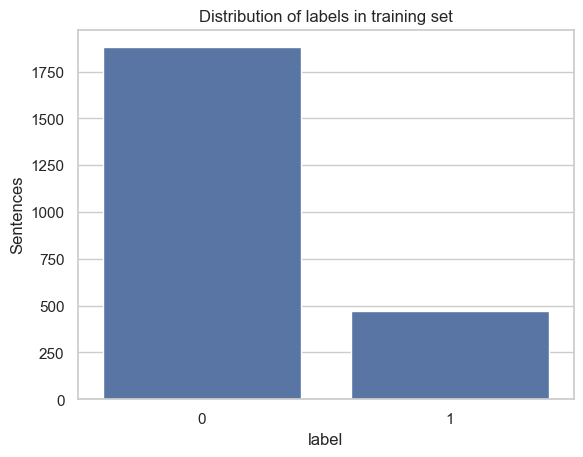

In [26]:
x = training_df['label'].value_counts()
sns.barplot(x)
sns.set(style="whitegrid")
plt.title('Distribution of labels in training set')
plt.gca().set_ylabel('Sentences')
plt.show()

In [27]:
test_df.shape

(941, 3)

In [28]:
test_df.head()

,sentence,label,phrase
0,also i want to be an optometrist and this class is part of that journey.,1,['Also I want to be an optometrist and this class is part of that journey.']
1,unfortunately it is a requirement for biology major students.,0,"[""I am here because this class is one of many classes I need to take to complete a bachelor's degree in biology.""]"
2,i am here to learn beyond my prior knowledge.,0,"[""I'm here because I need this class to graduate, but to zoom out, I'm in school to succeed. I am here to learn beyond my prior knowledge. I am here so that I am can become confident in speaking up and sharing my thoughts in an organized structure. I am here so I am knowledgeable enough to transform and create ideas and creations.""]"
3,i have no specific direction in my life other than the general goal i have always had since i knew how to talk.,0,['I want to try to get into veterinary school that is why I am in OCHEM.']
4,im here because i want to pursue a career in the medical field.,0,"['More specifically, this class will get me one step closer to my career goal']"


In [29]:
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Positive labels present in the test dataset : 118  out of 941 or 12.539851222104145%


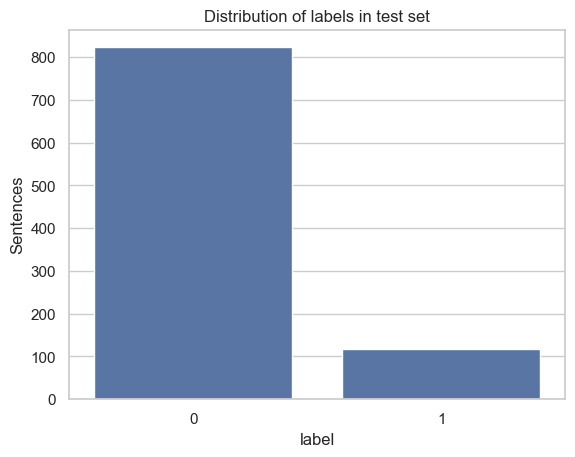

In [30]:
x1 = test_df['label'].value_counts()
sns.barplot(x1)
sns.set(style="whitegrid")
plt.title('Distribution of labels in test set')
plt.gca().set_ylabel('Sentences')
plt.show()

### FEATURE ENGINEERING

**1. NER**

In [31]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [32]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

**2. Similarity Features**

In [33]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [34]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

**3. Medical Word Count**

In [35]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['neuromuscular', 'imaging', 'immunology', 'psychosomatic', 'disabilities', 'anatomical', 'child', 'medical', 'behavioral', 'cardiothoracic', 'chemical', 'pediatrics', 'abdominal', 'disease', 'urologic', 'radiation', 'chest', 'endovascular', 'dermatology', 'surgery', 'dermatology', 'mental', 'psychiatry', 'adolescent', 'renal', 'transplant', 'urology', 'sports', 'ophthalmology', 'endocrinology', 'cytopathology', 'diseases', 'ophthalmology', 'pathology', 'critical', 'urology', 'allergy', 'critical', 'family', 'diabetes', 'neurodevelopmental', 'psychiatry', 'anesthesiology', 'adolescent', 'internal', 'genetic', 'surgery', 'genitourinary', 'cytogenetics', 'surgical', 'obstetrics', 'electrophysiology', 'pediatric', 'pelvic', 'glaucoma', 'occupational', 'palliative', 'neurourology', 'reproductive', 'cardiovascular', 'forensic', 'pain', 'pulmonology', 'banking', 'neuropathology', 'hepatology', 'radiology', 'neuroradiology', 'infectious', 'procedural', 'gynecologic', 'transplant', 'sleep', 'n

In [36]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

**4. Sentiment Polarity and Subjectivity**

In [37]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

**5. POS Tag Count**

In [38]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [39]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

**6. Word Embeddings**

In [40]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [41]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [42]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [45]:
# Function to split text into words
def split_into_words(text):
    return text.split()

**7. Unigrams**

In [266]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 3), min_df=2, stop_words = 'english')

**WRAPPER**

In [240]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [49]:
X_train, y_train = feature_engineering(training_df)

In [50]:
X_train.shape

(2350, 121)

In [51]:
y_train = y_train.astype('int')

In [52]:
X_test, y_test = feature_engineering(test_df)

In [140]:
X_test.shape

(941, 121)

In [141]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [207]:
X_train.shape

(2350, 121)

In [213]:
X_test.shape

(941, 121)

In [267]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (2350, 6574)


In [268]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [269]:
X_train_final.columns = X_train_final.columns.astype(str)

In [270]:
X_train_final.shape

(2350, 6695)

In [271]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (941, 6574)


In [272]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(941, 6695)

In [273]:
X_test_final.columns = X_test_final.columns.astype(str)

In [274]:
X_test_final.shape

(941, 6695)

In [275]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [158]:
X_train_final

,sentence,phrase,tokens,bio_sim_words,chem_sim_words,phy_sim_words,math_sim_words,tech_sim_words,eng_sim_words,medical_terms,...,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150
0,i don't want to give up because this is something that i really want to do.,"[""I'm here because I want to become a doctor in the near future."", 'I want to be the first in my family to graduate and become a doctor.']","[i, do, n't, want, to, give, up, because, this, is, something, that, i, really, want, to, do, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"not only am i making an impact on the medical field and women who are pregnant, but i am also changing the stem norms.",['go to medical school and become a doctor and eventually do medical research'],"[not, only, am, i, making, an, impact, on, the, medical, field, and, women, who, are, pregnant, ,, but, i, am, also, changing, the, stem, norms, .]",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,i am here to learn about physics in depth and observe the principles we learn in everyday classes and practice the logic behind the essential physics concepts.,"['I am here to learn about physics in depth and observe the principles we learn in everyday classes and practice the logic behind the essential physics concepts.', 'I am here to understand the use of the physics and get better the apply these concepts in computer engineering', 'Thus, I am here to learn physics and more to get better.']","[i, am, here, to, learn, about, physics, in, depth, and, observe, the, principles, we, learn, in, everyday, classes, and, practice, the, logic, behind, the, essential, physics, concepts, .]",2,2,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"i love science, and even though its hard and theres a lot of struggles, im sticking with it.",['Im here because I need help to pass OCHEM.'],"[i, love, science, ,, and, even, though, its, hard, and, theres, a, lot, of, struggles, ,, im, sticking, with, it, .]",1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,i hope this subject will teach me at least something valuable i can use in becoming a software engineer.,['I hope this subject will teach me at least something valuable I can use in becoming a software engineer.'],"[i, hope, this, subject, will, teach, me, at, least, something, valuable, i, can, use, in, becoming, a, software, engineer, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,i waited quite some time to take physics in my undergrad because ive had bad experiences in the past and the many times i enrolled in physics the professors i was stuck with were some of the worst professors ive ever taken here at sf state.,['If that is the case then I need this class to better prepare me for the physics portion of the MCAT.'],"[i, waited, quite, some, time, to, take, physics, in, my, undergrad, because, ive, had, bad, experiences, in, the, past, and, the, many, times, i, enrolled, in, physics, the, professors, i, was, stuck, with, were, some, of, the, worst, professors, ive, ever, taken, here, at, sf, state, .]",2,2,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2346,"by taking the time to make sure that i dont fall behind in my classes, i can really make sure i can devote more time to helping her with whatever she needs.",['I wanted to take this SI class so that I can be more confident in my physics skills so that I dont have to focus as much on my grades.'],"[by, taking, the, time, to, make, sure, that, i, dont, fall, behind, in, my, classes, ,, i, can, really, make, sure, i, can, devote, more, time, to, helping, her, with, whatever, she, needs, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2347,but i just haven't reached the conclusion of that question for myself.,"['I signed up to become a physicist, a career to become a physicist.']","[but, i, just, have, n't, reached, the, conclusion, of, that, question, for, myself, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2348,i am here to enjoy my life in a part of the world that is still som

In [276]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:6695]]

In [277]:
X_train_model_1.shape

(2350, 6584)

In [278]:
X_train_model_1.head(2)

,polarity,subjectivity,interjections,nouns,adverb,verb,determiner,pronoun,adjetive,preposition,...,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573
0,0.200000,0.2,0,2,2,3,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0.111111,0.5,0,5,3,2,3,0,3,1,...,0,0,0,0,0,0,0,0,0,0


In [279]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:6695]]

In [280]:
X_test_model_1.shape

(941, 6584)

In [281]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


Best score: 0.510
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9342    0.7764    0.8480       823
           1     0.2840    0.6186    0.3893       118

    accuracy                         0.7566       941
   macro avg     0.6091    0.6975    0.6187       941
weighted avg     0.8527    0.7566    0.7905       941



In [282]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 639, False Positive: 184, False Negative: 45, True Positive: 73
--------------------------------------------------------------------------------
[[639 184]
 [ 45  73]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       823
           1       0.28      0.62      0.39       118

    accuracy                           0.76       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.76      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.93 | 0.85 | 0.89 | 117 |
| Class 1 |0.51 | 0.72 | 0.60 | 25 |
| Macro Average Score | 0.72 | 0.79 | 0.75 | 142|

### Model 2: All Features

In [283]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:6695]]

In [284]:
X_train_model_2

,bio_sim_words,chem_sim_words,phy_sim_words,math_sim_words,tech_sim_words,eng_sim_words,medical_terms,polarity,subjectivity,ner,...,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573
0,0,0,0,0,0,0,0,0.200000,0.200000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0.111111,0.500000,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,2,0,0,0,-0.200000,0.533333,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0.104167,0.570833,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,-0.005556,0.527778,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2,2,0,2,0,0,0,-0.362500,0.604167,0,...,0,0,0,0,0,0,0,0,0,0
2346,0,0,0,0,0,0,0,0.260000,0.635556,0,...,0,0,0,0,0,0,0,0,0,0
2347,0,0,0,0,0,0,0,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2348,0,0,0,0,0,0,0,0.268182,0.477273,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
X_train_model_2.shape

(2350, 6692)

In [286]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:6695]]

In [80]:
X_test_model_2.shape

(941, 1110)

In [287]:
# from sklearn.preprocessing import StandardScaler
# # Updated pipeline with scaling
# model_2_pipeline = Pipeline([
#     # ('scaler', StandardScaler()),  # Feature scaling
#     ('clf', LogisticRegression(class_weight='balanced', random_state=18)),
# ])

# # Expanded parameter grid
# parameters = {
#     'clf__C': [0.0001, 0.001, 0.009, 0.01, 0.1, 1, 5, 10],
#     'clf__penalty': ["l2", "elasticnet"],  # Consider adding "elasticnet" if you decide to use it
#     'clf__solver': ['liblinear'],  # Include saga for larger datasets
# }

# # Using GridSearchCV with additional scoring
# grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv=10, n_jobs=-1, verbose=1)

# # Fitting the model
# grid_search.fit(X_train_model_2, y_train)

# # Best score and parameters
# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()

# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# # Classification report on test set
# print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best score: 0.515
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9352    0.7716    0.8455       823
           1     0.2824    0.6271    0.3895       118

    accuracy                         0.7535       941
   macro avg     0.6088    0.6993    0.6175       941
weighted avg     0.8533    0.7535    0.7883       941



In [288]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
# Fit the logistic regression model
lr_model_2 = LogisticRegression(random_state=18, 
                                 solver=best_parameters['clf__solver'], 
                                 C=best_parameters['clf__C'], 
                                 penalty=best_parameters['clf__penalty'], 
                                 class_weight='balanced').fit(X_train_model_2, y_train)

# Get predicted probabilities for the positive class
y_proba = lr_model_2.predict_proba(X_test_model_2)[:, 1]

# Set an initial threshold (0.5 is common, but can be adjusted)
threshold = 0.5
y_lr_adjusted = (y_proba >= threshold).astype(int)

# Compute confusion matrix and classification report
tn, fp, fn, tp = confusion_matrix(y_test, y_lr_adjusted).ravel()
print('Logistic Regression Classifier')
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr_adjusted))
print('-' * 80)
print(classification_report(y_test, y_lr_adjusted))

# Evaluate different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_lr_temp = (y_proba >= threshold).astype(int)
    temp_precision = precision_score(y_test, y_lr_temp)
    temp_recall = recall_score(y_test, y_lr_temp)
    print(f"Threshold: {threshold:.1f}, Precision: {temp_precision:.4f}, Recall: {temp_recall:.4f}")

Logistic Regression Classifier
True Negative: 635, False Positive: 188, False Negative: 44, True Positive: 74
--------------------------------------------------------------------------------
[[635 188]
 [ 44  74]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941

Threshold: 0.1, Precision: 0.1289, Recall: 0.9915
Threshold: 0.2, Precision: 0.1632, Recall: 0.9831
Threshold: 0.3, Precision: 0.2106, Recall: 0.9068
Threshold: 0.4, Precision: 0.2507, Recall: 0.7797
Threshold: 0.5, Precision: 0.2824, Recall: 0.6271
Threshold: 0.6, Precision: 0.2899, Recall: 0.4153
Threshold: 0.7, Precision: 0.3178, Recall: 0.2881
Threshold: 0.8, Precision: 0

In [289]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 635, False Positive: 188, False Negative: 44, True Positive: 74
--------------------------------------------------------------------------------
[[635 188]
 [ 44  74]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941



In [83]:
NameOfVariables = X_train_model_2.columns.values
Var_coef = zip(lr_model_2.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

embedding87 --- Value: -0.7502653635266809
147 --- Value: -0.5962951217304852
embedding94 --- Value: -0.5332583888146596
677 --- Value: -0.5144645632116854
521 --- Value: -0.4559533136973712
246 --- Value: -0.4427580396196941
embedding83 --- Value: -0.43209534954504925
375 --- Value: -0.4212025952004171
664 --- Value: -0.3849414344957855
embedding61 --- Value: -0.35833007126461724
324 --- Value: -0.3572434335147296
268 --- Value: -0.35322175135855116
266 --- Value: -0.3255522067305605
embedding88 --- Value: -0.31582831049442367
797 --- Value: -0.3141616457151748
657 --- Value: -0.307132961633981
embedding44 --- Value: -0.2983896735830322
532 --- Value: -0.28762322346194596
950 --- Value: -0.2863121976173992
embedding0 --- Value: -0.2796314306316954
embedding90 --- Value: -0.2731900499942016
subjectivity --- Value: -0.26705209101522465
773 --- Value: -0.2666967057667231
487 --- Value: -0.2514767447793343
embedding79 --- Value: -0.251221309061702
embedding9 --- Value: -0.2501391346874982

| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.88 | 0.92 | 117 |
| Class 1 |0.61 | 0.88 | 0.72 | 25 |
| Macro Average Score | 0.79 | 0.88 | 0.82 | 142|

### Model 3: Without Unigrams

In [290]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [291]:
X_train_model_3.shape

(2350, 118)

In [292]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [293]:
X_test_model_3.shape

(941, 118)

In [294]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.510
Best parameters set:
	clf__C: 25
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9467    0.6695    0.7843       823
           1     0.2423    0.7373    0.3648       118

    accuracy                         0.6780       941
   macro avg     0.5945    0.7034    0.5746       941
weighted avg     0.8584    0.6780    0.7317       941



In [295]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 551, False Positive: 272, False Negative: 31, True Positive: 87
--------------------------------------------------------------------------------
[[551 272]
 [ 31  87]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       823
           1       0.24      0.74      0.36       118

    accuracy                           0.68       941
   macro avg       0.59      0.70      0.57       941
weighted avg       0.86      0.68      0.73       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.99 | 0.82 | 0.90 | 117 |
| Class 1 |0.53 | 0.96 | 0.69 | 25 |
| Macro Average Score | 0.76 | 0.89 | 0.79 | 142|

### Model 4: Without Embeddings

In [296]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:6695]]

In [297]:
X_train_model_4.shape

(2350, 6592)

In [298]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:6695]]

In [299]:
X_test_model_4.shape

(941, 6592)

In [300]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
              'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.508
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9311    0.7716    0.8439       823
           1     0.2741    0.6017    0.3767       118

    accuracy                         0.7503       941
   macro avg     0.6026    0.6866    0.6103       941
weighted avg     0.8487    0.7503    0.7853       941



In [301]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 635, False Positive: 188, False Negative: 47, True Positive: 71
--------------------------------------------------------------------------------
[[635 188]
 [ 47  71]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       823
           1       0.27      0.60      0.38       118

    accuracy                           0.75       941
   macro avg       0.60      0.69      0.61       941
weighted avg       0.85      0.75      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.89 | 0.91 | 117 |
| Class 1 |0.58 | 0.72 | 0.64 | 25 |
| Macro Average Score | 0.76 | 0.80 | 0.78 | 142|

### Model 5: Without POS Tag Count

In [302]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:6695]]

In [303]:
X_train_model_5.shape

(2350, 6684)

In [304]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:6695]]

In [305]:
X_test_model_5.shape

(941, 6684)

In [306]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.524
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.61       941
weighted avg       0.85      0.75      0.79       941



In [307]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 632, False Positive: 191, False Negative: 44, True Positive: 74
--------------------------------------------------------------------------------
[[632 191]
 [ 44  74]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.61       941
weighted avg       0.85      0.75      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

In [308]:
NameOfVariables = X_train_model_5.columns.values
Var_coef = zip(lr_model_5.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

embedding87 --- Value: -0.5987004673902306
embedding94 --- Value: -0.48779165333731805
456 --- Value: -0.4585356874097425
embedding83 --- Value: -0.36568395180068924
2688 --- Value: -0.3461432157561555
2689 --- Value: -0.32966396290701155
1978 --- Value: -0.32369438461174127
4256 --- Value: -0.3164587051131339
1469 --- Value: -0.3161678647349821
embedding61 --- Value: -0.30694168960898105
827 --- Value: -0.2991994675544437
1079 --- Value: -0.29464902655488323
1287 --- Value: -0.29372167881803724
5723 --- Value: -0.2900128092074223
5942 --- Value: -0.2830482756872345
embedding90 --- Value: -0.2788412911408487
5075 --- Value: -0.2699737681973891
4576 --- Value: -0.26949386545153725
5014 --- Value: -0.26911027508776725
2573 --- Value: -0.26187082916692705
embedding88 --- Value: -0.2530028150043989
embedding44 --- Value: -0.2491307497262127
2027 --- Value: -0.24463055542928303
5666 --- Value: -0.23042229992373217
2542 --- Value: -0.2299793873373651
embedding45 --- Value: -0.225769841794296

### Model 6: Without STEM Similarity

In [309]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:6695]]

In [310]:
X_train_model_6.shape

(2350, 6685)

In [314]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:6695]]

In [315]:
X_test_model_6.shape

(941, 6685)

In [316]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.527
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       823
           1       0.28      0.62      0.39       118

    accuracy                           0.76       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.76      0.79       941



In [317]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 639, False Positive: 184, False Negative: 45, True Positive: 73
--------------------------------------------------------------------------------
[[639 184]
 [ 45  73]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       823
           1       0.28      0.62      0.39       118

    accuracy                           0.76       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.76      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.87 | 0.92 | 117 |
| Class 1 |0.59 | 0.88 | 0.71 | 25 |
| Macro Average Score | 0.78 | 0.88 | 0.81 | 142|

### Model 7: Without Sentiment Features

In [318]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:6695]]

In [319]:
X_train_model_7.shape

(2350, 6690)

In [320]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:6695]]

In [321]:
X_test_model_7.shape

(941, 6690)

In [322]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.516
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       823
           1       0.28      0.62      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941



In [323]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 635, False Positive: 188, False Negative: 45, True Positive: 73
--------------------------------------------------------------------------------
[[635 188]
 [ 45  73]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       823
           1       0.28      0.62      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.88 | 0.91 | 117 |
| Class 1 |0.58 | 0.76 | 0.66 | 25 |
| Macro Average Score | 0.76 | 0.82 | 0.78 | 142|

### Model 8: Without NER

In [324]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:6695]]

In [325]:
X_train_model_8.shape

(2350, 6691)

In [329]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:6695]]

In [330]:
X_test_model_8.shape

(941, 6691)

In [331]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.515
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941



In [332]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 635, False Positive: 188, False Negative: 44, True Positive: 74
--------------------------------------------------------------------------------
[[635 188]
 [ 44  74]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       823
           1       0.28      0.63      0.39       118

    accuracy                           0.75       941
   macro avg       0.61      0.70      0.62       941
weighted avg       0.85      0.75      0.79       941



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

### Final Summary

| S.No|Features| Precision | Recall | F1 |
| :-:| :-- | :-: |:-: | :-: |
| 1 |Embeddings + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER| 0.76 | 0.89 | 0.79 |
| 2 |Unigrams + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER  |0.76 | 0.80 | 0.78 |
| 3 |Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER | 0.76 | 0.85 | 0.79 |
| 4 |**Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + NER + POS Tag Count** | **0.78** | **0.88** | **0.81**|
| 5 |Embeddings + Unigrams + STEM Similarity + NER + POS Tag Count | 0.76 | 0.82 | 0.78|
| 6 |Embeddings + Unigrams + STEM Similarity + POS Tag Count + Sentiment (Polarity and Subjectivity) | 0.76 | 0.85 | 0.79|